In [1]:
!pip install langdetect
!pip install gensim

import numpy as np
np.random.seed(0)
import keras
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import glorot_uniform
from keras.models import Sequential
from keras.layers import Flatten
from keras.preprocessing.text import Tokenizer
np.random.seed(1)
import tensorflow as tf
import pandas as pd
import csv
import langdetect
import pickle
import gensim.models
from gensim.models import Word2Vec
from keras.preprocessing.text import one_hot
import statistics as st
from sklearn.metrics import confusion_matrix
import itertools
from collections import Counter




#Read CSV and do some first adjustments
%pylab inline
#read tweets
folder = "/Users/hovensa/OneDrive - delaware/Data science/WK/"
df1 = pd.read_csv(folder + "#rodeduivels_2018-06-11.csv", delimiter = ';')
df2 = pd.read_csv(folder + "#PorBel_2018-06-11.csv", delimiter = ';')
df3 = pd.read_csv(folder + "#BelPor_2018-06-06.csv", delimiter = ';')
df4 = pd.read_csv(folder + "DiablesRouges_2018-06-11.csv", delimiter = ';')
df5 = pd.read_csv(folder + "tweetsQuinten-2018-06-11.csv", delimiter = ';')
df6 = pd.read_csv(folder + "RSCA_2018-06-11.csv", delimiter = ';')
df7 = pd.read_csv(folder + "kaaGentAf_2018-06-11.csv", delimiter = ';')
dfTemp = [df1,df2,df3,df4,df5,df6,df7]
df = pd.concat(dfTemp, ignore_index="True")  
df_url = df.text[:].str.replace('http\S+|www.\S+', '', case=False)
df_RT = df_url.str.replace('RT ','',case=True)
df_tags = df_RT.str.replace('(@\w{0,})', '',case=False)
df_hash = df_tags.str.replace('(#\w{0,})', '',case=False)
df_col2 = df_hash.str.replace('FACEBOOK LIVE Q&amp;A: ','',case=False)
df_trim = df_col2.str.lstrip()

df_final = pd.DataFrame({"Emotion":df.Emotion, "text": df_trim})


Using TensorFlow backend.
C:\Users\hovensa\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Populating the interactive namespace from numpy and matplotlib


In [2]:
from collections import Counter

In [3]:
#define the written language of the tweet. If nor Dutch, nor French, it is set on NA

df_text = pd.DataFrame(df_final)
df_text['Language'] = ''
for index,i in df_text.iterrows():
    try: 
        if langdetect.detect(i.text) == 'af':
            i.Language = 'nl'
        if langdetect.detect(i.text) != 'nl' and langdetect.detect(i.text) != 'fr':
            i.Language = 'NA'
        else: 
            i.Language = langdetect.detect(i.text)
    except:
        i.Language = 'NA' 
df_filtered = df_text[df_text['Language'] != 'NA'] 

In [4]:
#Detect emoticons and add the right word to the dataframe
def DefineEmoticons(language,text):
    
    emoticondf = pd.read_csv(open(folder + "emoticons_"+language+".txt",'rt'), delimiter = "\t")
    text["emotion_"+language] = ""
    for index,line in text.iterrows():
        for index,row in emoticondf.iterrows():
            if(row.Emoticon in line.text): 
                line["emotion_"+language] = row.Description
           
    return text

text_ad = DefineEmoticons("nl",df_filtered)
text_ad = DefineEmoticons("en",text_ad)       
text_ad = DefineEmoticons("fr",text_ad)  

C:\Users\hovensa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [5]:
#the addition of an emotion word to the tweet text
text_ad['emotion']= ''
for index,i in text_ad.iterrows():

        if i.Language == 'nl':
            i.emotion = i.emotion_nl
        if i.Language == 'fr':
            i.emotion = i.emotion_fr
        if i.Language == 'en':
            i.emotion = i.emotion_en
        else:
            '' 
            
text_ad['text'] = text_ad['text'].map(str) + ' '+ text_ad['emotion'] 

C:\Users\hovensa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hovensa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
#Replace all exclamation marks and question marks, since they can contain some sentiment
for index,tweet in text_ad.iterrows():
    if tweet.Language == 'nl':
        tweet.text = tweet.text.replace('!',' uitroepteken')
        tweet.text = tweet.text.replace('?',' vraagteken')
        text_ad.loc[index,:].text = tweet.text
    else: 
        if tweet.Language == 'fr':
            tweet.text = tweet.text.replace('!', ' point d\'exclamation')
            tweet.text = tweet.text.replace('?',' point d\'interrogation')
            text_ad.loc[index,:].text = tweet.text

        else: 
            tweet.text = tweet.text.replace('!', ' exclamation mark')
            tweet.text = tweet.text.replace('?',' question mark')
            text_ad.loc[index,:].text = tweet.text


In [7]:
sentences = []
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
for word in text_ad.text: 
    no_punct = ""
    for char in word:
        if char not in punctuations:
            no_punct = no_punct + char
    sentence = no_punct.lower().split()
    sentences.append(sentence)

In [8]:
#split in Test and Train
def createTrainTest(DataSet):
    #replace the missing Values
    #replacement with most occurent class
    #Mode = st.mode(DataSet.Emotion.dropna())
    #DataSet.Emotion.fillna(Mode,inplace = True)
    DataSet.dropna(inplace = True)
    #Create TRAIN VAL en TEST but first randomize data
    indexesDS = pd.DataFrame({'i':range(1,len(DataSet),1)})
    indexesR = indexesDS.sample(frac = 1)
    #TRAIN = 75%
    iTrain = indexesR[1:round(0.75 * len(DataSet))]
    TRAINset = DataSet.iloc[iTrain.iloc[:,0]]
    TRAIN = TRAINset.iloc[:,1:(len(DataSet.columns))]
    yTrain = TRAINset.iloc[:,0]
    #VAL = 20%
    #iVal = indexesR[round(0.6 * len(DataSet)):round(0.8 * len(DataSet))]
    #VAL = DataSet.loc[iVal.iloc[:,0]]
    #TEST = 25%
    iTest = indexesR[round(0.75 * len(DataSet)):len(DataSet)]
    TESTset = DataSet.iloc[iTest.iloc[:,0]]
    TEST = TESTset.iloc[:,1:(len(DataSet.columns))]
    yTest= TESTset.iloc[:,0]
    return TRAIN,TEST,yTrain,yTest

In [9]:
#Obtain a wordvector for each tweet
def word2Vec(df,language):

    model = gensim.models.Word2Vec.load(folder + language + '.bin')  # you can continue training with the loaded model!    
    #create the appropriate format to plot the tweets in a vectorspace
    #punctuation can be deleted now since the emotions are already converted
    sentences = []
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for word in df.text: 
        no_punct = ""
        for char in word:
            if char not in punctuations:
                no_punct = no_punct + char
        sentence = no_punct.lower().split()
        sentences.append(sentence)

    #store each vector representation of a word of a tweet in a list 'vectors'
    vectors = []
    vocab = model.wv.vocab
    counter = 0
    lent = 0
    counterw = 0
    for w in sentences:
        vector = []
        lenw = len(w)
        lent = lent + lenw
        counterw = 0
        for i in w:
            if i in vocab:
                vector.append(model[i])
                counterw = counterw + 1
                counter = counter + 1
            else: 
                print(i)
                
               
        print(counterw/lenw)
        vectors.append(vector)
    print("total")
    print(counter/lent)
    return vectors


In [10]:
#get the indices and create padded lists for each tweet
def tweet_embedding_and_indexing(df,word_vec,MaxLenTweet):
    
    #flatten the word_vector list in order to be usable in the following steps
    flat_list = [item for sublist in word_vec for item in sublist]
    
    #initiate the tokenizer --> is used to assign indeces to the words in a tweet
    t = Tokenizer()
    t.fit_on_texts(df.text)
    
    #how many words can be found in the dataset --> not taking into account those that are not found in the word2vec mechanism 
    vocab_size = len(flat_list)
    #split the tweets into words
    encoded_docs = t.texts_to_sequences(df.text)

    #fill the tweet lists until max_length is reahced with 0 --> necessary for the creation of the embedding layer
    padded_docs = pad_sequences(encoded_docs, maxlen= MaxLenTweet, padding='post')
    
    #create the embedding layer with the weights based on the vector space
    e = Embedding((vocab_size), 300, weights= [np.array(flat_list)], input_length= MaxLenTweet, trainable=False)
    
    return padded_docs,e

In [11]:
#calculate the model
def LSTMModel(df,language):
    #What is the max length of a sequence of words in a tweet
    MaxLenTweet = 40#max(df.text.apply(lambda x : len(x.split())))  
    
    #create train/Test set with Yvar
    Train,Test,ytrain,ytest = createTrainTest(df)
    
    #obtain Word_vec
    vectorsTrain = word2Vec(Train,language)
    vectorsTest = word2Vec(Test,language)
    
    #obtain indeces array
    TrainIndices,embeddings = tweet_embedding_and_indexing(Train,vectorsTrain,MaxLenTweet)
    
    ###convert y var to classes
    classes = ytrain.unique()
    print(classes)
    NrClasses = len(ytrain.unique())
    ConvertClass = dict()
    for i in range(NrClasses):
        ConvertClass[classes[i]] = i
    yTrainNum = ytrain.replace(ConvertClass,regex = True)
    yTestNum = ytest.replace(ConvertClass, regex = True)

    #convert output to one-hot
    y_train = keras.utils.to_categorical(yTrainNum, NrClasses)#de y var moet naar 5 verschillende classen(cijfers) omgezet worden
    y_test = keras.utils.to_categorical(yTestNum, NrClasses)
    
    
    #map indeces and the embedding
    #the shape shows that it will receive sequences of length MaxLenTweet
    sentence_indices = Input(shape = (MaxLenTweet,), dtype='int32')
    #embeddings will encode the sequences into vectors
    emb_lay = embeddings(sentence_indices)
    print('creation model')
    #create the LSTM framework
    X = LSTM(150, return_sequences=True)(emb_lay)
    #dropout is that information that is not taken to the next iteration? with a probability of 0.5
    X = Dropout(0.5)(X)
    #second layer --> hidden
    X = LSTM(150, return_sequences=False)(X)
    X = Dropout(0.5)(X)
    X = Dense(NrClasses)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices, outputs=X)
    #divide train in val and train with CV
  
    #obtain min index to divide train and val
    #Min = round((len(df)/k)*(i-1)+1)
    #obtain  max index to divide train and val
    #Max = round((len(df)/k*i))
    #create a val and train set to create the model
    print(round(0.25*len(TrainIndices)))
    val = TrainIndices[1 : round(0.25*len(TrainIndices))]
    yval = y_train[1 : round(0.25*(len(TrainIndices)))]
    train = np.delete(TrainIndices,range(round((0.25*len(TrainIndices)+1)),len(TrainIndices)),0)
    ytrain = np.delete(y_train,range(round((0.25*len(y_train)+1)),len(y_train)),0)

    #train = TrainIndices.delete(TrainIndices.index[round((0.25*len(TrainIndices)+1)):len(TrainIndices)])
    #ytrain = y_train.delete(y_train.index[round((0.25*len(y_train)+1)):len(y_train)])
    #train the model
    print("model summary of " + language)
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('create the model of ' + language)
    #Shuffle means that you are going to shuffle the data between the batches
    model.fit(TrainIndices, y_train, epochs = 50, batch_size = 32, shuffle=True,validation_split = 0.25)#validation_data =(val,yval))
    
    TestIndices,_ =  tweet_embedding_and_indexing(Test,vectorsTest,MaxLenTweet)
    loss, acc = model.evaluate(TestIndices, y_test)

    print("Test accuracy of " + language + " = ", acc)
    
    #predict
    pred = model.predict(TestIndices)
    
    #switch key and value, in order to map words wuth columnindex                
    bDict = {val:key for (key, val) in ConvertClass.items()}
    yDF = pd.DataFrame(pred)
    y = yDF.apply(lambda x: int(np.argmax(x)), axis=1)
    print(y)
    y = y.replace(bDict,regex = True)
    
    return model,y,ytest
   

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [13]:
DatasetNl = text_ad[text_ad.Language == 'nl']
DatasetFr = text_ad[text_ad.Language == 'fr']

In [14]:
modelNl,PredictNl,yTestNl = LSTMModel(DatasetNl,'nl')
#modelFr,PredictFr,yTestFr = LSTMModel(DatasetFr,'fr')

C:\Users\hovensa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
lineup
où
suivezvous
0.85
mediocore
yesterdays
oefenwedst
0.8125
1.0
devroe
devroe
engagé
0.8333333333333334
1.0
100e
0.9230769230769231
01
47
dejaegere
0.25
lineup
où
suivezvous
0.85
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
1.0
truffels
0.9545454545454546
nainggolan
olé
olé
stilviel
htt
0.7058823529411765
tvcommentaar
mute
0.8947368421052632
lineup
où
suivezvous
0.85
coucke
saelemaekers
0.3333333333333333
433
0.9565217391304348
éénpersoonsvennootschappen
0.8888888888888888
zekerheden
0.8888888888888888
1.0
fifareglement
0.9375
kwaliteitsinjectie
kaagent
kwaliteitsinjectie
0.8421052631578947
1.0
1.0
deschacht
akern
retrouve
0.7692307692307693
fifareglement
0.9375
1.0
1.0
krampen
0.8571428571428571
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
1.0
1.0
lineup
où
suivezvous
0.85
1.0
11
0.9411764705882353
blesseert
thuislaten
0.8888888888888888
vannieuwkerke
0.9090909090909091
najar
sleutelpion
0.875
1.0
rimpe

C:\Users\hovensa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



0.5
vanhaezebrouck
anderlechtcoach
0.8666666666666667
verzoeningsgebaar
nainggolan
0.8
supporteren
0.9583333333333334
boyata
benteke
januzaj
chadli
sterrenteam
tactical
reasons
0.6818181818181818
lineup
où
suivezvous
0.85
1e
0.9545454545454546
weiler
hasi
holsbeeck
0.8421052631578947
wk2018
0.9285714285714286
tweet
0.9166666666666666
vandenbempt
0.875
lineup
où
suivezvous
0.85
lichtpunt
0.8
matchday
blokpauze
0.8666666666666667
25
jplwedstrijd
0.8947368421052632
vanderhaeghe
0.95
radjazuigers
fluiters
0.8823529411764706
1.0
1.0
boyata
benteke
januzaj
chadli
sterrenteam
tactical
reasons
0.6818181818181818
sprankeltje
0.8888888888888888
voorbeschouwing
0.6666666666666666
2045u
tennissen
malaga
0.8125
02
0.9473684210526315
lvb
schellebelle
0.75
lineup
où
suivezvous
0.85
flateren
0.9473684210526315
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
opwarmen
0.6666666666666666
1.0
1.0
1.0
schreeuwde
0.9230769230769231
holsbeeck
amp
0.8888888888888888
1.0
speelklaar
riskeren
0.90909090

nainggolan
0.8181818181818182
lineup
où
suivezvous
0.85
1.0
lineup
où
suivezvous
0.85
dendoncker
0.95
videoref
geldhof
penaltyge
0.8333333333333334
titelmatch
0.9444444444444444
1.0
lineup
où
suivezvous
0.85
1.0
coninx
0.9583333333333334
merchandise
0.9
vanhaezebrouck
spelleiding
videoref
0.8421052631578947
vanhaezebrouck
ganvoula
josué
0.8421052631578947
blokpauze
0.9090909090909091
1.0
lineup
où
suivezvous
0.85
vanhaezebrouck
deschacht
0.7777777777777778
lastminute
veldje
0.8333333333333334
1.0
inbeelden
0.9230769230769231
boyata
benteke
januzaj
chadli
sterrenteam
tactical
reasons
0.6818181818181818
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
boudewijnstadion
cocommentator
bilde
0.7692307692307693
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
grinta
rolex
toiletzak
handber
0.6923076923076923
18
0.9565217391304348
sterkhouder
respecteert
coucke
0.625
saelemaekers
0.9
pintjes
zekerheden
0.875
1.0
seg
0.9473684210526315
weeral
2
individue
0.85
bilde
morren
minderwa

0.85
1.0
buffalos
sclessin
playoff
1
po2
0.6875
5
buffalos
0.875
amp
amp
0.875
verzoeningsgebaar
nainggolan
0.8
1.0
1.0
leukste
0.875
fifareglement
0.9375
boyata
benteke
januzaj
chadli
sterrenteam
tactical
reasons
0.6818181818181818
lichtpunt
0.8
2
0
0.8666666666666667
lineup
où
suivezvous
0.85
lineup
où
suivezvous
0.85
devroe
devroe
engagé
0.8333333333333334
1.0
pintjes
zekerheden
0.875
vanhaezebrouck
spelleiding
videoref
0.8421052631578947
getweet
0.95
lineup
où
suivezvous
0.85
thuisduels
0.9473684210526315
onyekuru
najar
0.7142857142857143
jestrovic
markovic
9
0.6666666666666666
simuleerden
0.9375
dendoncker
kabasele
played
0.8
deschacht
anderlechtspelers
0.875
00
lulkoek
0.9047619047619048
fifareglement
0.9375
meevalt
fitte
0.8888888888888888
1.0
vandenbempt
creã«ert
lemen
0.75
pintjes
zekerheden
0.875
mambourg
0.9375
onthutsend
bayat
0.8181818181818182
lineup
où
suivezvous
0.85
fifareglement
0.9375
lukakus
praatjes
0.9047619047619048
95
0.9230769230769231
simuleerden
0.9375
devroe

youngster
0.9375
zekerheden
1
2
kwetst
0.7333333333333333
voetballiefhebbers
0.9
verzoeningsgebaar
nainggolan
0.8
buffalos
langszij
0.8888888888888888
1.0
lichtpunt
0.8
balbezit
0.9545454545454546
brechtje
papegaaiduiker
0.8461538461538461
pintjes
zekerheden
0.875
17
0.9090909090909091
minilandje
0.9444444444444444
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
fifareglement
0.9375
holsbeeck
0.8
lineup
où
suivezvous
0.85
topvoetballer
0.9333333333333333
lineup
où
suivezvous
0.85
1.0
morioka
0.8888888888888888
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
boezemvriend
0.9375
1.0
zekerheden
1
2
kwetst
0.7333333333333333
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
1.0
1e
0.9545454545454546
nainggolan
0.9285714285714286
twittert
proficiat
0.8947368421052632
1.0
0
0
0.6
lineup
où
suivezvous
0.85
1.0
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
1.0
jestrovic
markovic
9
0.6666666666666666
0
0.875

0.9375
automatismen
0.9545454545454546
2
2018
0.75
00
0.875
mechele
deere
minde
0.8695652173913043
lineup
où
suivezvous
0.85
bangelijk
scandeert
0.8823529411764706
scoreloos
0.8888888888888888
playoff
1
0.8461538461538461
eetfeest
supportersclub
poppies
passé
aujourdhui
rendr
0.6842105263157895
elvendertig
0.9090909090909091
1e
0.9545454545454546
saelemaekers
aploeg
proficiat
amp
sae
0.7727272727272727
playoff
1
0.8571428571428571
1.0
1.0
tvcommentaar
mute
0.8947368421052632
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
oefenmatch
0.9411764705882353
ideeen
0.9411764705882353
vanhaezebrouck
0.9166666666666666
scoreloos
0.8888888888888888
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
vertongen
wss
choco
0.7692307692307693
verzoeningsgebaar
nainggolan
0.8
exref
gumienny
anderlechtspelers
gezwaai
vanhaezebrouck
0.6875
vechtlust
0.8571428571428571
fifareglement
0.9375
deschacht
0.9230769230769231
wandelvoetbal
0.857

lierke
plezierke
0.6
1.0
voorbereidingsmatch
0.9230769230769231
lineup
où
suivezvous
0.85
105
0.9615384615384616
weeral
2
individue
0.85
tss
0.95
1.0
seieuze
45min
rookgordijn
vlotdraaiende
0.8333333333333334
playoff
1
zotte
aardverschuivingen
0.7777777777777778
00
0.875
belgiëpanama
0.9
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
mambourg
0.9375
11
alderweireld
vertonghen
dembele
carrasco
lukak
0.625
gefluit
nainggolan
0.9090909090909091
anderlechtdebutant
kalmeren
0.7777777777777778
opwarmen
0.6666666666666666
1.0
lineup
où
suivezvous
0.85
thuislaten
nainggola
0.9
1.0
lineup
où
suivezvous
0.85
gars
tjrs
0.5
vandenbempt
kegeltje
0.8181818181818182
1.0
heizel
kutstadion
0.7142857142857143
scoutingscel
makelaars
0.8888888888888888
lineup
où
suivezvous
0.85
verzoeningsgebaar
nainggolan
0.8
naingolan
0.875
00
0.9523809523809523
mazzutime
1a
beerschotwilrijk
0.8421052631578947
couckenbak
mauves
0.75
datge
rajda
nainngolan
0.8636363636363636
ingegroeid
haartje
bil
4
0.75
verzoen

Epoch 2/50
2149/2149 [==============================] - 8s 4ms/step - loss: 1.5387 - acc: 0.3262 - val_loss: 1.5220 - val_acc: 0.3431
Epoch 3/50
2149/2149 [==============================] - 6s 3ms/step - loss: 1.5363 - acc: 0.3383 - val_loss: 1.5139 - val_acc: 0.3431
Epoch 4/50
2149/2149 [==============================] - 7s 3ms/step - loss: 1.5319 - acc: 0.3262 - val_loss: 1.5094 - val_acc: 0.3431
Epoch 5/50
2149/2149 [==============================] - 10s 5ms/step - loss: 1.5297 - acc: 0.3355 - val_loss: 1.5123 - val_acc: 0.3431
Epoch 6/50
2149/2149 [==============================] - 10s 4ms/step - loss: 1.5292 - acc: 0.3346 - val_loss: 1.5163 - val_acc: 0.3431
Epoch 7/50
2149/2149 [==============================] - 9s 4ms/step - loss: 1.5298 - acc: 0.3364 - val_loss: 1.5107 - val_acc: 0.3431
Epoch 8/50
2149/2149 [==============================] - 9s 4ms/step - loss: 1.5280 - acc: 0.3369 - val_loss: 1.5106 - val_acc: 0.3431
Epoch 9/50
2149/2149 [==============================] - 9s 4

In [15]:
modelFr,PredictFr,yTestFr = LSTMModel(DatasetFr,'fr')
#modelFr,PredictFr,yTestFr = LSTMModel(DatasetFr,'fr')

C:\Users\hovensa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\hovensa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


joujou
mintéresses
bisou
0.75
dinterrogation
suivez
0.9047619047619048
dexclamation
nenvoie
28
occup
0.8181818181818182
matchday
belgiqueportugal
0.7142857142857143
goffin
dexclamation
0.8181818181818182
lamentable
0.8333333333333334
regardez
lapp
dexclamation
téléchargez
0.8095238095238095
romelu
lukaku
mitemps
marouane
fel
0.7619047619047619
rassurant
0.9090909090909091
dexclamation
0.9230769230769231
cétait
0.8
lhymne
2
0.8461538461538461
|
23
0.9047619047619048
110
000
dexclamation
signez
0.7333333333333333
1
griezmann
fortnite
dexclamation
dexclamation
dexclamation
ladresse
0.6666666666666666
alderweireld
kompany
vertonghen
bruyne
dembélé
carrasco
luk
0.5625
1.0
dury
dinterrogation
lintéressé
0.5714285714285714
lattentat
0.9444444444444444
1.0
jai
saelemaekers
dexclamation
dénergie
dexclamation
0.782608695652174
lattentat
0.9444444444444444
vertonghen
100e
0.8
dinterrogation
jattends
lanalyse
factuelle
lami
0.7222222222222222
lukaku
mbappé
0.9047619047619048
quon
const
0.904761904

mbappé
0.9047619047619048
1.0
23
21
0.8888888888888888
1.0
00
00
0.875
dexclamation
cétait
dexclamation
dimpact
0.8461538461538461
10
dinterrogation
0.8461538461538461
20h45
0.9333333333333333
quit
0.9
chadli
huées
deurope
0.8125
wauw
quil
leuro
0.875
konpany
0.9444444444444444
lhymne
2
0.8461538461538461
affronterons
dexclamation
0.75
maltraitants
lavais
rsca
mea
culpa
peutêtre
dinterrogation
0.6666666666666666
mdr
japprends
«
cétait
demifinale
»
0.7142857142857143
suray
fêtards
quil
0.8125
davoir
pourraitil
0.8666666666666667
1.0
popopo
archi
déquipes
0.7692307692307693
02
mdr
60
0.7857142857142857
durbuy
cétait
dexclamation
durbuy
0.8260869565217391
dexclamation
0.9090909090909091
spéculer
jeulà
0.9
28
000
limmigration
dexclamation
signez
0.5454545454545454
tactiquement
individualités
0.8823529411764706
tweets
0.9473684210526315
lastuce
poke
0.8333333333333334
kompany
dinterrogation
0.9090909090909091
aujourdhui
0.9473684210526315
gerkens
0.95
januzaj
0.9285714285714286
januzaj
0.93

remette
0.9375
3e
0.9230769230769231
20h45
bein
1
0.7272727272727273
vertonghen
100e
0.8
guerreiro
affrontera
michy
batshuayi
dexclamation
0.6875
dinquiétudes
denseignements
0.75
1.0
alderweireld
kompany
vertonghen
bruyne
dembélé
carrasco
luk
0.5625
110
000
dexclamation
signez
0.7333333333333333
20h45
0.9333333333333333
1.0
laffaire
détat
signez
0.75
jai
pouvions
lorsqu
0.85
90minutes
0.9230769230769231
laffaire
détat
signez
0.75
dexclamation
nenvoie
28
occup
0.8181818181818182
lukaku
mbappé
0.9047619047619048
détestent
0.9583333333333334
1.0
quaresma
0.9
pep
guardiola
bruyne
dinterrogation
mettez
0.7368421052631579
lukaku
mbappé
0.9047619047619048
00
dexclamation
0.8947368421052632
lhymne
2
0.8461538461538461
20h45
0.9333333333333333
1.0
lukaku
mbappé
0.9047619047619048
topper
12
u21
0.6666666666666666
quon
const
0.9047619047619048
dinterrogation
0.9411764705882353
aujourdhui
0.9473684210526315
dexclamation
0.8333333333333334
dexclamation
belgiqueportugal
2045
dexclamation
0.733333333

wilmots
5
quil
0.8125
aujourdhui
dexclamation
0.9
holsbeeck
15
0.875
1.0
dinterrogation
0.9
00
dexclamation
0.8947368421052632
00
dexclamation
0.8823529411764706
rassuré
coucke
0.7777777777777778
00
00
préparat
0.8
laffaire
détat
signez
0.75
28
000
limmigration
dexclamation
signez
0.5454545454545454
24
3
0.9090909090909091
romelu
lukaku
mitemps
marouane
fel
0.7619047619047619
quavant
0.9411764705882353
20h45
bein
1
0.7272727272727273
mdr
0.9285714285714286
laffaire
détat
signez
0.75
alderweireld
kompany
vertonghen
bruyne
dembélé
carrasco
luk
0.5625
1.0
cétait
1er
jattends
légyptecosta
+
+
doccas
0.65
pourrie
trebel
0.8181818181818182
najar
0.8333333333333334
20h45
0.9333333333333333
chadli
huées
deurope
0.8125
1.0
00
dexclamation
0.8947368421052632
20h45
bein
1
0.7272727272727273
20h45
0.9333333333333333
20h45
0.9333333333333333
mdr
0.9
quon
const
0.9047619047619048
mmmh
compo
wietsel
3
jai
peutêtre
0.5714285714285714
quaresma
0.9
110
000
dexclamation
signez
0.7333333333333333
equipe
0

0.7272727272727273
dattaquant
20h45
bein
0.8
léquipe
dexclamation
0.6666666666666666
léquipe
0.9583333333333334
15
défensi
0.9230769230769231
guedes
0.75
bakary
02
0.8333333333333334
dexclamation
0.9
1.0
davant
larrivée
0.8461538461538461
lhomme
merite
0.9130434782608695
coucke
holsbeeck
nest
0.8636363636363636
jai
0.9230769230769231
dhabitude
1
1
0.7272727272727273
diablementfoot
0.9375
jespère
quon
0.8571428571428571
1.0
dinterrogation
quavant
hâtives
déj
0.8181818181818182
tweets
0.9473684210526315
dexclamation
0.75
saelemaekers
quil
déj
0.85
1.0
alderweireld
kompany
vertonghen
bruyne
dembélé
carrasco
luk
0.5625
sold
darriver
lavance
daccès
0.7894736842105263
28
000
limmigration
dexclamation
signez
0.5454545454545454
demmanuel
dinterrogation
signez
0.7692307692307693
tactiquement
individualités
0.8947368421052632
dinquiétudes
denseignements
0.75
dinterrogation
chier
0.8823529411764706
1.0
lanimation
lukaku
0.8947368421052632
pcq
2
pleureuses
0.8333333333333334
1.0
1er
lobjectif
zo
0

creation model
443
model summary of fr
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 40, 300)           6632100   
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 150)           270600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 150)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6

590/590 [==============================] - 1s 1ms/step
Test accuracy of fr =  0.323728813711
0      4
1      2
2      5
3      5
4      1
5      3
6      4
7      5
8      1
9      4
10     5
11     5
12     4
13     4
14     5
15     1
16     3
17     4
18     5
19     1
20     4
21     1
22     4
23     1
24     3
25     1
26     5
27     3
28     1
29     5
      ..
560    0
561    4
562    0
563    5
564    1
565    4
566    1
567    0
568    1
569    1
570    2
571    5
572    1
573    5
574    0
575    4
576    1
577    1
578    4
579    4
580    4
581    5
582    1
583    5
584    1
585    0
586    4
587    4
588    5
589    4
Length: 590, dtype: int64


In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(yTestNl, PredictNl)
np.set_printoptions(precision=2)
class_names =sorted(yTestNl.unique())
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [955, 590]

Confusion matrix, without normalization
[[  7   6  14  19   4   3]
 [ 10  28  12  15   4   2]
 [ 31  38 116  57  12  21]
 [  5  24  18  29   3   7]
 [  9  35  21  13   2   1]
 [  4   3   5   3   0   9]]
Normalized confusion matrix
[[ 0.13  0.11  0.26  0.36  0.08  0.06]
 [ 0.14  0.39  0.17  0.21  0.06  0.03]
 [ 0.11  0.14  0.42  0.21  0.04  0.08]
 [ 0.06  0.28  0.21  0.34  0.03  0.08]
 [ 0.11  0.43  0.26  0.16  0.02  0.01]
 [ 0.17  0.12  0.21  0.12  0.    0.38]]


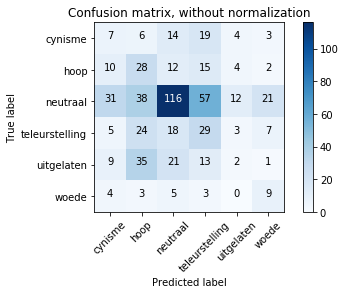

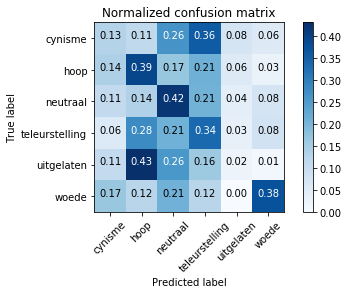

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(yTestFr, PredictFr)
np.set_printoptions(precision=2)
class_names =sorted(yTestFr.unique())
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [37]:
# serialize model to JSON
model_json = modelNl.to_json()
with open(folder + "modelLSTMnl.json", "w") as json_file:
    json_file.write(model_json)
model_json = modelFr.to_json()
with open(folder + "modelLSTMfr.json", "w") as json_file:
    json_file.write(model_json)

Vanaf hier chaos